In [1]:
import os
import pydicom
from pprint import pprint
from dicom_visitors import *

# Directory containing MRI studies
mri_data_root = "/home/lukasd/src/hpc-predict/data/v0/input_data/original/mri/MRT Daten Bern/"

In [2]:
%%script false --no-raise-error

## Compare DICOM files listed in DICOMDIR to those available in subfolders

list_of_dicom_dir_files = []
list_of_dicom_dir_series = []
list_of_dicom_dir_studies = []
list_of_dicom_dir_patients = []
def list_of_dicom_dir_files_append(image_filename, dcm_image, dcmdir_entry):
    list_of_dicom_dir_files.append(image_filename) 
    list_of_dicom_dir_series.append(dcmdir_entry['series'].SeriesInstanceUID)
    list_of_dicom_dir_studies.append(dcmdir_entry['study'].StudyInstanceUID)
    list_of_dicom_dir_patients.append(dcmdir_entry['patient'].PatientID)
    
list_of_dicom_files = []
list_of_dicom_series = []
list_of_dicom_studies = []
list_of_dicom_patients = []
def list_of_dicom_files_append(image_filename, dcm_image):
    list_of_dicom_files.append(image_filename)
    list_of_dicom_series.append(dcm_image.SeriesInstanceUID)
    list_of_dicom_studies.append(dcm_image.StudyInstanceUID)
    list_of_dicom_patients.append(dcm_image.PatientID)
    
def validate_dicom_dir_collection(mri_data_root, max_dirs=2):
    mri_data_collection = sorted([s.path for s in os.scandir(mri_data_root) if s.is_dir()], key=lambda x: int(os.path.basename(x)))
    
    for mri_data_sample in mri_data_collection if max_dirs is None else mri_data_collection[:max_dirs]:
        # fetch the path to the test data
        mri_data_path = os.path.join(mri_data_root, mri_data_sample)
        
        visit_dicom_files(mri_data_path, list_of_dicom_files_append)
        
        filepath = os.path.join(mri_data_path, 'DICOMDIR')
        print('Validating DICOMDIR for {}...'.format(mri_data_path))
        dicom_dir = pydicom.filereader.read_dicomdir(filepath)
        base_dir = os.path.dirname(filepath)

        visit_dicom_dir(base_dir, dicom_dir, list_of_dicom_dir_files_append)
        
        for entity, list_dicom_files, list_dicom_dir in [('files',    list_of_dicom_files,    list_of_dicom_dir_files), 
                                                         ('series',   list_of_dicom_series,   list_of_dicom_dir_series),
                                                         ('studies',  list_of_dicom_studies,  list_of_dicom_dir_studies),
                                                         ('patients', list_of_dicom_patients, list_of_dicom_dir_patients)]:
            set_dicom_files = set(list_dicom_files)
            set_dicom_dir = set(list_dicom_dir)
            diff_files_to_dicom = set_dicom_files.difference(set_dicom_dir)

            if len(diff_files_to_dicom) > 0:
                diff_files_to_dicom_list = sorted(list(diff_files_to_dicom))
                print(" " * 4 + "Found {} {} in DICOMDIR and {} on filesystem. Only on filesystem:".format(len(set_dicom_dir), entity, len(set_dicom_files)))
                pprint(diff_files_to_dicom_list if len(diff_files_to_dicom_list) < 10 else diff_files_to_dicom_list[:10], indent=4)


            list_dicom_files.clear()
            list_dicom_dir.clear()
        
validate_dicom_dir_collection(mri_data_root)

In [3]:
%%script false --no-raise-error

# Compute value range of selected DICOM header fields based on images referenced in DICOMDIR files

accumulate_attributes = ['ImageOrientationPatient', 'ImagePositionPatient'] #['MRAcquisitionType', 'ImageType', 'Modality'] # 'CardiacNumberOfImages', 'PatientAge'

accumulators = {accumulate_attribute: (('patient', {}), 
                                       ('study', {}), 
                                       ('series', {})) for accumulate_attribute in accumulate_attributes}
group_by = {'patient': 'PatientID', 
            'study': 'StudyInstanceUID', 
            'series': 'SeriesInstanceUID'}

def accumulate_visitor(image_filename, dcm_image, dcmdir_entry):
    for accumulate_attribute in accumulate_attributes:
        for dcm_type, accumulator in accumulators[accumulate_attribute]: #[('patient', accumulate_by_patient), ('study', accumulate_by_study), ('series',accumulate_by_series)]:
            key = getattr(dcmdir_entry[dcm_type], group_by[dcm_type])
            attribute = getattr(dcm_image, accumulate_attribute)
            if type(attribute) in [list, pydicom.multival.MultiValue]:
                attribute = tuple(attribute)
            if key in accumulator:
                accumulator[key].add(attribute)
            else:
                accumulator[key] = set([attribute])
            #print("{}: {}".format(image_filename, dcm_image.CardiacNumberOfImages))
    
#visit_dicom_dir(base_dir, dicom_dir, accumulate_visitor)
visit_dicom_dir_collection(mri_data_root, accumulate_visitor, max_dirs=1)

for accumulate_attribute in accumulate_attributes:
    for dcm_type, accumulator in accumulators[accumulate_attribute]:
        pprint("{} grouped by {} ({} -> {}):".format(accumulate_attribute, dcm_type, group_by[dcm_type], accumulate_attribute), indent=12)
        pprint(accumulator, indent=12)
    pprint("{} aggregated for all patients:".format(accumulate_attribute), indent=12)
    accumulated_attribute_set = set()
    for attribute_set in accumulators[accumulate_attribute][0][1].values():
        accumulated_attribute_set = accumulated_attribute_set.union(attribute_set)
    pprint(accumulated_attribute_set, indent=12)


In [4]:
%%script false --no-raise-error

# Compute value range of selected DICOM header fields based on all DICOM files

accumulate_attributes = ['ImageOrientationPatient', 'ImagePositionPatient'] #['MRAcquisitionType', 'ImageType', 'Modality'] # 'CardiacNumberOfImages', 'PatientAge'

accumulators = {accumulate_attribute: (('patient', {}), 
                                       ('study', {}), 
                                       ('series', {})) for accumulate_attribute in accumulate_attributes}
group_by = {'patient': 'PatientID', 
            'study': 'StudyInstanceUID', 
            'series': 'SeriesInstanceUID'}

def accumulate_visitor(image_filename, dcm_image):
    # Apply filter
    if not(dcm_image.MRAcquisitionType == '3D' and \
                ('M' in dcm_image.ImageType or 'P' in dcm_image.ImageType) and \
                dcm_image.Modality == 'MR'):
        print(" " * 4 + "Skipping {} due to lack of phase/magnitude image type".format(image_filename))# TODO: print range of headers of excluded images
    for accumulate_attribute in accumulate_attributes:
        for dcm_type, accumulator in accumulators[accumulate_attribute]: #[('patient', accumulate_by_patient), ('study', accumulate_by_study), ('series',accumulate_by_series)]:
            key = getattr(dcm_image, group_by[dcm_type])
            attribute = getattr(dcm_image, accumulate_attribute)
            if type(attribute) in [list, pydicom.multival.MultiValue]:
                attribute = tuple(attribute)
            if key in accumulator:
                accumulator[key].add(attribute)
            else:
                accumulator[key] = set([attribute])
            #print("{}: {}".format(image_filename, dcm_image.CardiacNumberOfImages))
    
#visit_dicom_dir(base_dir, dicom_dir, accumulate_visitor)
visit_dicom_file_collection(mri_data_root, accumulate_visitor, max_dirs=1)

for accumulate_attribute in accumulate_attributes:
    for dcm_type, accumulator in accumulators[accumulate_attribute]:
        pprint("{} grouped by {} ({} -> {}):".format(accumulate_attribute, dcm_type, group_by[dcm_type], accumulate_attribute), indent=12)
        pprint(accumulator, indent=12)
    pprint("{} aggregated for all patients:".format(accumulate_attribute), indent=12)
    accumulated_attribute_set = set()
    for attribute_set in accumulators[accumulate_attribute][0][1].values():
        accumulated_attribute_set = accumulated_attribute_set.union(attribute_set)
    pprint(accumulated_attribute_set, indent=12)

In [5]:
# Data exploration

mri_sample = "3"
mri_data_path = os.path.join(mri_data_root, mri_sample)

In [6]:
%%bash -s "$mri_data_path"
tree --filelimit 10 "$1"

/home/lukasd/src/hpc-predict/data/v0/input_data/original/mri/MRT Daten Bern/3
├── 10000000
│   └── 10000001
│       ├── 10000002 [2070 entries exceeds filelimit, not opening dir]
│       ├── 10000007 [690 entries exceeds filelimit, not opening dir]
│       ├── 10000013 [51 entries exceeds filelimit, not opening dir]
│       └── 100017F5
│           └── 100017F6
├── 1001A34A
│   └── 1001A34B
│       ├── 1001A34C [2070 entries exceeds filelimit, not opening dir]
│       └── 10030217 [690 entries exceeds filelimit, not opening dir]
└── DICOMDIR

10 directories, 2 files


In [7]:
## https://pydicom.github.io/pydicom/stable/auto_examples/input_output/plot_read_dicom_directory.html#sphx-glr-auto-examples-input-output-plot-read-dicom-directory-py

# authors : Guillaume Lemaitre <g.lemaitre58@gmail.com>
# license : MIT

# fetch the path to the test data
filepath = os.path.join(mri_data_path, 'DICOMDIR')
print('Path to the DICOM directory: {}'.format(filepath))
# load the data
dicom_dir = pydicom.filereader.read_dicomdir(filepath)
base_dir = os.path.dirname(filepath)

Path to the DICOM directory: /home/lukasd/src/hpc-predict/data/v0/input_data/original/mri/MRT Daten Bern/3/DICOMDIR


In [8]:
## Overview of header fields
print("*** DICOMDIR ***")
pprint(dicom_dir)

*** DICOMDIR ***
{(0004, 1130): (0004, 1130) File-set ID                         CS: '1',
 (0004, 1200): (0004, 1200) Offset of the First Directory Recor UL: 374,
 (0004, 1202): (0004, 1202) Offset of the Last Directory Record UL: 374,
 (0004, 1212): (0004, 1212) File-set Consistency Flag           US: 0,
 (0004, 1220): <Sequence, length 2764>}


In [9]:
patient_record = dicom_dir.patient_records[0]
print("*** PATIENT ***")
pprint(patient_record)

*** PATIENT ***
{(0004, 1400): (0004, 1400) Offset of the Next Directory Record UL: 0,
 (0004, 1410): (0004, 1410) Record In-use Flag                  US: 65535,
 (0004, 1420): (0004, 1420) Offset of Referenced Lower-Level Di UL: 504,
 (0004, 1430): (0004, 1430) Directory Record Type               CS: 'PATIENT',
 (0008, 0005): (0008, 0005) Specific Character Set              CS: 'ISO_IR 100',
 (0010, 0010): (0010, 0010) Patient's Name                      PN: 'Anonymous3^Patient',
 (0010, 0020): (0010, 0020) Patient ID                          LO: 'ANONYM-REVX4'}


In [10]:
study = patient_record.children[0]
print("*** STUDY ***")
pprint(study)

*** STUDY ***
{(0004, 1400): (0004, 1400) Offset of the Next Directory Record UL: 0,
 (0004, 1410): (0004, 1410) Record In-use Flag                  US: 65535,
 (0004, 1420): (0004, 1420) Offset of Referenced Lower-Level Di UL: 708,
 (0004, 1430): (0004, 1430) Directory Record Type               CS: 'STUDY',
 (0008, 0005): (0008, 0005) Specific Character Set              CS: 'ISO_IR 100',
 (0008, 0020): (0008, 0020) Study Date                          DA: '20090323',
 (0008, 0030): (0008, 0030) Study Time                          TM: '162952.234',
 (0008, 0050): (0008, 0050) Accession Number                    SH: 'XIYJUKXLJH',
 (0020, 000d): (0020, 000d) Study Instance UID                  UI: 1.2.40.0.13.1.237828120959059386345548749032058253715,
 (0020, 0010): (0020, 0010) Study ID                            SH: ''}


In [11]:
series = study.children[0]
print("*** SERIES ***")
pprint(series)

*** SERIES ***
{(0004, 1400): (0004, 1400) Offset of the Next Directory Record UL: 1757982,
 (0004, 1410): (0004, 1410) Record In-use Flag                  US: 65535,
 (0004, 1420): (0004, 1420) Offset of Referenced Lower-Level Di UL: 904,
 (0004, 1430): (0004, 1430) Directory Record Type               CS: 'SERIES',
 (0008, 0005): (0008, 0005) Specific Character Set              CS: 'ISO_IR 100',
 (0008, 0021): (0008, 0021) Series Date                         DA: '20090323',
 (0008, 0031): (0008, 0031) Series Time                         TM: '171351.031',
 (0008, 0060): (0008, 0060) Modality                            CS: 'MR',
 (0020, 000e): (0020, 000e) Series Instance UID                 UI: 1.2.40.0.13.1.25036309036536625224276724877695836772,
 (0020, 0011): (0020, 0011) Series Number                       IS: "10"}


In [12]:
image_record = series.children[0]
print("*** IMAGE ***")
#pprint(dir(image_record))
pprint(image_record)

*** IMAGE ***
{(0004, 1400): (0004, 1400) Offset of the Next Directory Record UL: 1752,
 (0004, 1410): (0004, 1410) Record In-use Flag                  US: 65535,
 (0004, 1420): (0004, 1420) Offset of Referenced Lower-Level Di UL: 0,
 (0004, 1430): (0004, 1430) Directory Record Type               CS: 'IMAGE',
 (0004, 1500): (0004, 1500) Referenced File ID                  CS: ['1001A34A', '1001A34B', '1001A34C', '1001A34D'],
 (0004, 1510): (0004, 1510) Referenced SOP Class UID in File    UI: MR Image Storage,
 (0004, 1511): (0004, 1511) Referenced SOP Instance UID in File UI: 1.2.40.0.13.1.214339010389129923903255300662291473381,
 (0004, 1512): (0004, 1512) Referenced Transfer Syntax UID in F UI: Implicit VR Little Endian,
 (0008, 0005): (0008, 0005) Specific Character Set              CS: 'ISO_IR 100',
 (0008, 0022): (0008, 0022) Acquisition Date                    DA: '20090323',
 (0008, 0032): (0008, 0032) Acquisition Time                    TM: '165409.150',
 (0008, 1140): <Sequenc

*** SINGLE IMAGE FILE ***
Image filename: /home/lukasd/src/hpc-predict/data/v0/input_data/original/mri/MRT Daten Bern/3/1001A34A/1001A34B/1001A34C/1001A34D
{(0008, 0005): (0008, 0005) Specific Character Set              CS: 'ISO_IR 100',
 (0008, 0008): (0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'P', 'DIS2D'],
 (0008, 0012): (0008, 0012) Instance Creation Date              DA: '20090323',
 (0008, 0013): (0008, 0013) Instance Creation Time              TM: '171419.671',
 (0008, 0016): (0008, 0016) SOP Class UID                       UI: MR Image Storage,
 (0008, 0018): (0008, 0018) SOP Instance UID                    UI: 1.2.40.0.13.1.214339010389129923903255300662291473381,
 (0008, 0020): (0008, 0020) Study Date                          DA: '20090323',
 (0008, 0021): (0008, 0021) Series Date                         DA: '20090323',
 (0008, 0022): (0008, 0022) Acquisition Date                    DA: '20090323',
 (0008, 0023): (0008, 0023) Content Date    

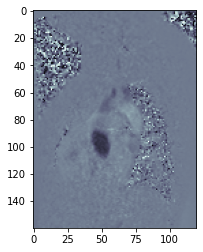

In [13]:
# DICOM tags can be checked here:
# https://www.dicomstandard.org/current
# e.g. in http://dicom.nema.org/medical/dicom/current/output/html/part03.html

image_filename = os.path.join(base_dir, *image_record.ReferencedFileID)
dicom_img = pydicom.dcmread(image_filename)
print("*** SINGLE IMAGE FILE ***")
print("Image filename: {}".format(image_filename))
pprint(dicom_img)
import matplotlib.pyplot as plt
plt.imshow(dicom_img.pixel_array, cmap=plt.cm.get_cmap('bone'))
plt.show()

In [14]:
# Exploratory analysis with pandas

import pydicom
import pandas as pd
from pprint import pprint

# Data generated with convert_dicom_to_pandas.py
df = pd.read_pickle("/home/lukasd/src/hpc-predict/data/v0/input_data/preprocessed/mri/MRT Daten Bern DICOM Header/3.pkl")

# Drop columns with NaN entries
# filtered_df = df.loc[:, df.loc[0].notnull()]
non_null_df = df.dropna(how='any',axis=1)

In [15]:
# Check for uniqueness of VR
non_null_vrs = non_null_df.applymap(lambda x: x.VR)

non_null_vrs = non_null_df.applymap(lambda x: x.VR).drop_duplicates()
non_null_vrs = non_null_vrs.transpose().rename(columns={0:'VR'})
non_null_vrs

,VR
"(0008, 0005)",CS
"(0008, 0008)",CS
"(0008, 0012)",DA
"(0008, 0013)",TM
"(0008, 0016)",UI
...,...
"(0029, 0010)",LO
"(0029, 0011)",LO
"(0032, 1064)",SQ
"(0051, 0010)",LO


In [16]:
# Check for uniqueness of name
non_null_names = non_null_df.applymap(lambda x: x.name).drop_duplicates()
non_null_names = non_null_names.transpose().rename(columns={0:'name'})
non_null_names

,name
"(0008, 0005)",Specific Character Set
"(0008, 0008)",Image Type
"(0008, 0012)",Instance Creation Date
"(0008, 0013)",Instance Creation Time
"(0008, 0016)",SOP Class UID
...,...
"(0029, 0010)",Private Creator
"(0029, 0011)",Private Creator
"(0032, 1064)",Requested Procedure Code Sequence
"(0051, 0010)",Private Creator


In [17]:
# Check for uniqueness of keyword
non_null_keywords = non_null_df.applymap(lambda x: x.keyword).drop_duplicates()
non_null_keywords = non_null_keywords.transpose().rename(columns={0:'keyword'})
non_null_keywords

,keyword
"(0008, 0005)",SpecificCharacterSet
"(0008, 0008)",ImageType
"(0008, 0012)",InstanceCreationDate
"(0008, 0013)",InstanceCreationTime
"(0008, 0016)",SOPClassUID
...,...
"(0029, 0010)",
"(0029, 0011)",
"(0032, 1064)",RequestedProcedureCodeSequence
"(0051, 0010)",


In [18]:
non_null_names_keywords_vrs = \
     pd.concat([non_null_names,
                non_null_keywords,
                non_null_vrs], axis=1)

#non_null_names_keywords = non_null_names.join(non_null_keywords)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(non_null_names_keywords_vrs.to_string())

print("Null values in either name, keyword or type for:")
non_null_names_keywords_vrs[non_null_names_keywords_vrs.isnull().any(axis=1)]


                                                    name                                  keyword  VR
(0008, 0005)                      Specific Character Set                     SpecificCharacterSet  CS
(0008, 0008)                                  Image Type                                ImageType  CS
(0008, 0012)                      Instance Creation Date                     InstanceCreationDate  DA
(0008, 0013)                      Instance Creation Time                     InstanceCreationTime  TM
(0008, 0016)                               SOP Class UID                              SOPClassUID  UI
(0008, 0018)                            SOP Instance UID                           SOPInstanceUID  UI
(0008, 0020)                                  Study Date                                StudyDate  DA
(0008, 0021)                                 Series Date                               SeriesDate  DA
(0008, 0023)                                Content Date                          

,name,keyword,VR


In [19]:
# Rename columns by name and extract values
#column_renaming = {i.tag: i.name for i in non_null_df.loc[0,:]}
non_null_df_renamed = non_null_df.rename(columns=non_null_names.loc[:,'name'].to_dict()).applymap(lambda x: x.value)
non_null_df_renamed

,Specific Character Set,Image Type,Instance Creation Date,Instance Creation Time,SOP Class UID,SOP Instance UID,Study Date,Series Date,Content Date,Study Time,...,Largest Image Pixel Value,Longitudinal Temporal Information Modified,Window Center,Window Width,Window Center & Width Explanation,Private Creator,Private Creator,Requested Procedure Code Sequence,Private Creator,filepath
0,ISO_IR 100,"[ORIGINAL, PRIMARY]",20110625,182705.250,1.2.840.10008.5.1.4.1.1.4,1.2.40.0.13.1.18217426757998275037614733832236...,20110625,20110625,20110625,175702.234,...,1024,MODIFIED,256.0,512.0,Algo1,SIEMENS CSA HEADER,SIEMENS MEDCOM HEADER2,"[{(0008, 0100): (0008, 0100) Code Value ...",SIEMENS MR HEADER,/home/lukasd/src/hpc-predict/data/v0/input_dat...
1,ISO_IR 100,"[ORIGINAL, PRIMARY]",20110625,182705.281,1.2.840.10008.5.1.4.1.1.4,1.2.40.0.13.1.20452092643374306756386350109540...,20110625,20110625,20110625,175702.234,...,1024,MODIFIED,256.0,512.0,Algo1,SIEMENS CSA HEADER,SIEMENS MEDCOM HEADER2,"[{(0008, 0100): (0008, 0100) Code Value ...",SIEMENS MR HEADER,/home/lukasd/src/hpc-predict/data/v0/input_dat...
2,ISO_IR 100,"[ORIGINAL, PRIMARY]",20110625,183405.234,1.2.840.10008.5.1.4.1.1.4,1.2.40.0.13.1.15479401915262115973399514975196...,20110625,20110625,20110625,175702.234,...,1024,MODIFIED,256.0,512.0,Algo1,SIEMENS CSA HEADER,SIEMENS MEDCOM HEADER2,"[{(0008, 0100): (0008, 0100) Code Value ...",SIEMENS MR HEADER,/home/lukasd/src/hpc-predict/data/v0/input_dat...
3,ISO_IR 100,"[ORIGINAL, PRIMARY]",20110625,182705.265,1.2.840.10008.5.1.4.1.1.4,1.2.40.0.13.1.25697292688449655338696274200789...,20110625,20110625,20110625,175702.234,...,1024,MODIFIED,256.0,512.0,Algo1,SIEMENS CSA HEADER,SIEMENS MEDCOM HEADER2,"[{(0008, 0100): (0008, 0100) Code Value ...",SIEMENS MR HEADER,/home/lukasd/src/hpc-predict/data/v0/input_dat...
4,ISO_IR 100,"[ORIGINAL, PRIMARY]",20110625,183405.281,1.2.840.10008.5.1.4.1.1.4,1.2.40.0.13.1.26643637538516871539873548542368...,20110625,20110625,20110625,175702.234,...,2000,MODIFIED,256.0,512.0,Algo1,SIEMENS CSA HEADER,SIEMENS MEDCOM HEADER2,"[{(0008, 0100): (0008, 0100) Code Value ...",SIEMENS MR HEADER,/home/lukasd/src/hpc-predict/data/v0/input_dat...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,ISO_IR 100,"[ORIGINAL, PRIMARY, P, DIS2D]",20090323,171432.828,1.2.840.10008.5.1.4.1.1.4,1.2.40.0.13.1.98519309881565925576130969305884...,20090323,20090323,20090323,162952.234,...,4094,MODIFIED,-156.0,4518.0,Algo1,SIEMENS CSA HEADER,SIEMENS MEDCOM HEADER2,"[{(0008, 0100): (0008, 0100) Code Value ...",SIEMENS MR HEADER,/home/lukasd/src/hpc-predict/data/v0/input_dat...
5568,ISO_IR 100,"[ORIGINAL, PRIMARY, P, DIS2D]",20090323,171409.531,1.2.840.10008.5.1.4.1.1.4,1.2.40.0.13.1.28005958063928916554994256969008...,20090323,20090323,20090323,162952.234,...,4091,MODIFIED,-136.0,4498.0,Algo1,SIEMENS CSA HEADER,SIEMENS MEDCOM HEADER2,"[{(0008, 0100): (0008, 0100) Code Value ...",SIEMENS MR HEADER,/home/lukasd/src/hpc-predict/data/v0/input_dat...
5569,ISO_IR 100,"[ORIGINAL, PRIMARY, P, DIS2D]",20090323,171419.421,1.2.840.10008.5.1.4.1.1.4,1.2.40.0.13.1.42898990129133471596298092676719...,20090323,20090323,20090323,162952.234,...,4095,MODIFIED,-118.0,4490.0,Algo1,SIEMENS CSA HEADER,SIEMENS MEDCOM HEADER2,"[{(0008, 0100): (0008, 0100) Code Value ...",SIEMENS MR HEADER,/home/lukasd/src/hpc-predict/data/v0/input_dat...
5570,ISO_IR 100,"[ORIGINAL, PRIMARY, P, DIS2D]",20090323,171423.968,1.2.840.10008.5.1.4.1.1.4,1.2.40.0.13.1.59488720043191463322755114295608...,20090323,20090323,20090323,162952.234,...,4091,MODIFIED,-122.0,4490.0,Algo1,SIEMENS CSA HEADER,SIEMENS MEDCOM HEADER2,"[{(0008, 0100): (0008, 0100) Code Value ...",SIEMENS MR HEADER,/home/lukasd/src/hpc-predict/data/v0/input_dat...


In [20]:
# Types joined on header names
non_null_df_python_types_vrs = pd.concat([ non_null_df_renamed.applymap(lambda col: type(col)).drop_duplicates().transpose().rename(columns={0: 'Python Type'}), non_null_names_keywords_vrs.rename(index=non_null_names.loc[:,'name'].to_dict())], axis=1 )
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(non_null_df_python_types_vrs.to_string() )

                                                                      Python Type                                        name                                  keyword  VR
Specific Character Set                                              <class 'str'>                      Specific Character Set                     SpecificCharacterSet  CS
Image Type                                  <class 'pydicom.multival.MultiValue'>                                  Image Type                                ImageType  CS
Instance Creation Date                                              <class 'str'>                      Instance Creation Date                     InstanceCreationDate  DA
Instance Creation Time                                              <class 'str'>                      Instance Creation Time                     InstanceCreationTime  TM
SOP Class UID                                           <class 'pydicom.uid.UID'>                               SOP Class UID                    

In [21]:
# TODO: Evaluate the columns: range of values for each column

# TBD: Sequences need to be treated separately

non_null_df_renamed_no_seq = non_null_df_renamed.loc[:,(non_null_df_python_types_vrs['VR'] != 'SQ') & 
                                                       (non_null_df_python_types_vrs['name'] != 'Acquisition Matrix')
                                                    ]

for col in non_null_df_renamed_no_seq.columns:
    print("*** {} ***".format(col))
    pprint(non_null_df_renamed_no_seq[col].apply(lambda x: repr(x)).unique(), indent=4) # TBD: repr is currently just a hack to make it work, to implement properly need to convert all the data types in each column


*** Specific Character Set ***
array(["'ISO_IR 100'"], dtype=object)
*** Image Type ***
array(["['ORIGINAL', 'PRIMARY']", "['ORIGINAL', 'PRIMARY', 'P', 'DIS2D']",
       "['ORIGINAL', 'PRIMARY', 'M', 'DIS2D']"], dtype=object)
*** Instance Creation Date ***
array(["'20110625'", "'20090323'"], dtype=object)
*** Instance Creation Time ***
array(["'182705.250'", "'182705.281'", "'183405.234'", ...,
       "'171432.687'", "'171414.296'", "'171418.718'"], dtype=object)
*** SOP Class UID ***
array(["'1.2.840.10008.5.1.4.1.1.4'"], dtype=object)
*** SOP Instance UID ***
array(["'1.2.40.0.13.1.182174267579982750376147338322360501010'",
       "'1.2.40.0.13.1.204520926433743067563863501095409452493'",
       "'1.2.40.0.13.1.154794019152621159733995149751960329584'", ...,
       "'1.2.40.0.13.1.4289899012913347159629809267671990089'",
       "'1.2.40.0.13.1.5948872004319146332275511429560891735'",
       "'1.2.40.0.13.1.330536109407927773026020620196311760392'"],
      dtype=object)
*** Study Date

<AxesSubplot:>

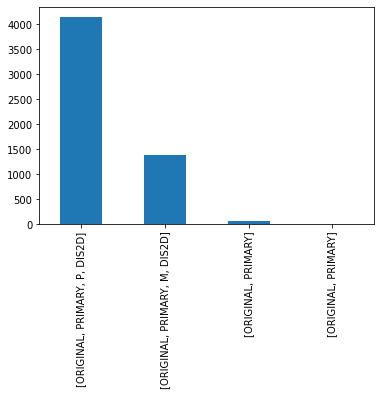

In [22]:
non_null_df_renamed['Image Type'].value_counts().plot(kind='bar')

<AxesSubplot:>

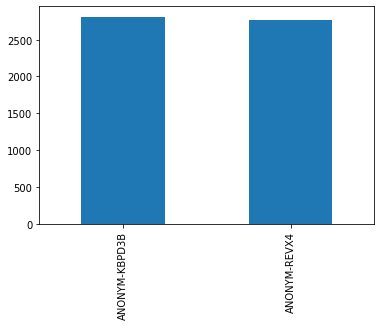

In [23]:
non_null_df_renamed['Patient ID'].value_counts().plot(kind='bar')

<AxesSubplot:>

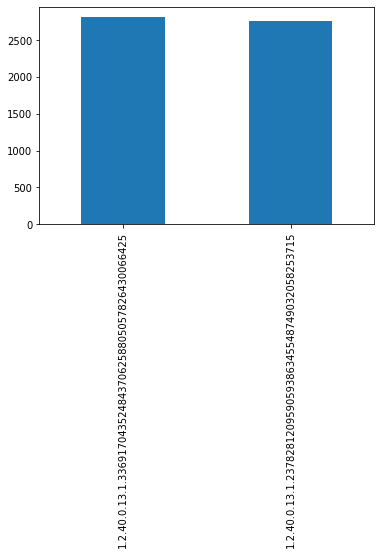

In [24]:
non_null_df_renamed['Study Instance UID'].value_counts().plot(kind='bar')

<AxesSubplot:>

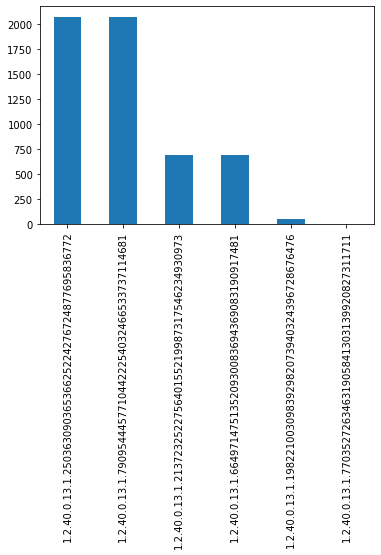

In [25]:
non_null_df_renamed['Series Instance UID'].value_counts().plot(kind='bar')

<AxesSubplot:>

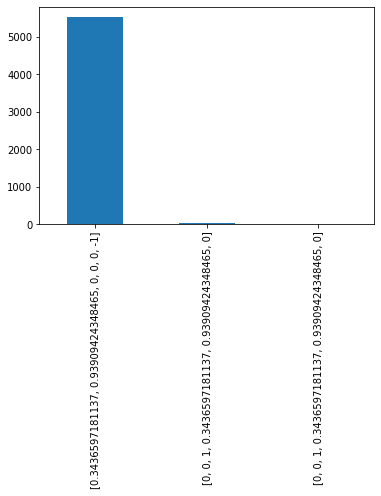

In [26]:
non_null_df_renamed['Image Orientation (Patient)'].value_counts().plot(kind='bar')

In [27]:
# Group by patient/study UID/series, etc.
non_null_df_renamed_by_patient = non_null_df_renamed.groupby('Patient ID')

#... etc.